In [1]:
pip install torch transformers regex safetensors gcsfs torchvision

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install transformers torch scikit-learn pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
!nvidia-smi

Wed Aug 23 13:17:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    17W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from transformers import get_linear_schedule_with_warmup, BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import StepLR
from torch.optim import AdamW
import torch.optim as optim
import torch.quantization
import torch.nn as nn
import os
import numpy as np
import time
import pandas as pd
import numpy as np

In [5]:
import torch
torch.cuda.empty_cache()

In [6]:
import pandas as pd

# Define the path to the CSV file in GCS
csv_path = "gs://vino-verdict/data/wine_3scale.csv"

# Read the CSV using pandas
df = pd.read_csv(csv_path)

In [7]:
df.head()

,country,description,points,price,province,region_1,title,variety,winery,year,verdict
0,US,"Good acidity on this clean, vibrant wine, with...",87,20.000000,California,Santa Ynez Valley,Tercero 2009 Camp 4 Grenache Blanc (Santa Ynez...,Grenache Blanc,Tercero,2009,bad
1,US,Soft on the palate and built on a foundation o...,85,51.571429,California,Calistoga,Sterling 2012 Cellar Club Cabernet Sauvignon (...,Cabernet Sauvignon,Sterling,2012,bad
2,US,Sweetly extracted fruit and oak star in this r...,88,50.000000,California,Los Carneros,Talisman 2009 Adastra Vineyard Pinot Noir (Los...,Pinot Noir,Talisman,2009,bad
3,Chile,The bouquet is fairly exotic as it kicks up so...,85,17.000000,Central Valley,NaN,Valdivieso 2000 Single Vineyard Reserve Merlot...,Merlot,Valdivieso,2000,bad
4,US,A simple Pinot Noir that was a little sweet an...,82,40.000000,California,Russian River Valley,B.R. Cohn 2009 Pinot Noir (Russian River Valley),Pinot Noir,B.R. Cohn,2009,bad


In [8]:
df['verdict'].value_counts()

bad          5868
average      5868
excellent    5868
Name: verdict, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split

# Splitting the dataframe
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['verdict'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['verdict'], random_state=42)

In [10]:
train_df.shape, valid_df.shape, test_df.shape

((14083, 11), (1760, 11), (1761, 11))

In [11]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the descriptions from the train, validation, and test sets
train_encodings = tokenizer(list(train_df['description']), truncation=True, padding=True, max_length=128, return_tensors='pt')
val_encodings = tokenizer(list(valid_df['description']), truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(list(test_df['description']), truncation=True, padding=True, max_length=128, return_tensors='pt')

train_encodings.keys()  # Display the keys to check the tokenization results

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [14]:
# Convert 'bad', 'good', and 'excellent' to 0, 1, and 2, respectively
train_labels = train_df['verdict'].replace({'bad': 0, 'average': 1, 'excellent': 2}).to_numpy()
val_labels = valid_df['verdict'].replace({'bad': 0, 'average': 1, 'excellent': 2}).to_numpy()
test_labels = test_df['verdict'].replace({'bad': 0, 'average': 1, 'excellent': 2}).to_numpy()

# Convert to PyTorch tensors
train_labels = torch.tensor(train_labels).long()
val_labels = torch.tensor(val_labels).long()
test_labels = torch.tensor(test_labels).long()

# Create datasets
train_dataset = torch.utils.data.TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
val_dataset = torch.utils.data.TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
test_dataset = torch.utils.data.TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

In [15]:
!nvidia-smi

Wed Aug 23 13:21:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    68W /  70W |   4823MiB / 15360MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# Training hyperparameters and initialization
batch_size = 16
epochs = 5
patience = 2

# Lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []

# Early stopping and model saving initializations
best_val_loss = float('inf')
no_improve_epochs = 0
path_to_save = "gs://vino-verdict/models/3_case_v3_cleaned_df.bin"

In [18]:
# DataLoader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)

# Load the BERT model for multi-class classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    num_labels=3,
    hidden_dropout_prob=0.1  # Adjust the dropout rate here
)
model = model.to(device)

# Loss function for binary cross entropy
# Use BCEWithLogitsLoss for binary classification with logits (includes sigmoid activation)
loss_function = nn.CrossEntropyLoss()

# Optimizer with a smaller learning rate
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

# Linear scheduler with warmup
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0, 
                                            num_training_steps=len(train_loader)*epochs)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [19]:
# Assuming you've already adjusted preprocessing and data loading to produce labels as 0, 1, or 2 
# corresponding to 'bad', 'average', and 'good'
from torch.quantization import default_observer, default_qconfig, QConfig

# Early stopping variables
best_val_f1 = -float('inf')
no_improve_epochs = 0
patience = 3
epochs = 5
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []
train_accuracies = []
gradient_accumulation_steps = 2

print("Starting training...\n")

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    train_predictions, train_true_vals = [], []

    optimizer.zero_grad()

    for step, batch in enumerate(train_loader):
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        
        loss = loss_function(outputs.logits, labels)  # Ensure this is categorical cross-entropy
        total_train_loss += loss.item()

        # Gradient accumulation
        loss = loss / gradient_accumulation_steps
        loss.backward()

        # Get predictions for training data
        batch_train_predictions = torch.argmax(outputs.logits, dim=1)
        train_predictions.extend(batch_train_predictions.cpu().numpy())
        train_true_vals.extend(labels.cpu().numpy())
        
        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()  # Update the learning rate
            optimizer.zero_grad()
            
        if step % 100 == 0:
            print(f"Epoch {epoch+1} - Step {step}/{len(train_loader)} - Loss: {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    train_accuracy = accuracy_score(train_true_vals, train_predictions)
    train_accuracies.append(train_accuracy)

    scheduler.step()

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_vals = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
            outputs = model(input_ids, attention_mask=attention_mask)
            
            val_loss += loss_function(outputs.logits, labels).item()
            
            batch_predictions = torch.argmax(outputs.logits, dim=1)
            predictions.extend(batch_predictions.cpu().numpy())
            true_vals.extend(labels.cpu().numpy())
                
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    val_accuracy = accuracy_score(true_vals, predictions)
    val_f1 = f1_score(true_vals, predictions, average='weighted')  # Adjusted for multiclass
    
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    
    print(f"\nEpoch {epoch+1}/{epochs} Summary:")
    print(f"Training Loss: {avg_train_loss:.4f} - Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f} - Validation F1: {val_f1:.4f}\n")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs == patience:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break

    # Save the best model based on validation F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        print("Saving the best model based on validation F1 score...\n")
        
        # Save the original model directly to Google Cloud Storage
        temp_model_path = f"./3_case_v3_cleaned_df_epoch_{epoch}.bin"
        torch.save(model.state_dict(), temp_model_path)
        os.system(f"gsutil cp {temp_model_path} {path_to_save}")
        
        # Save the model configuration for the regular model
        regular_model_config_path = "./3_case_v3_cleaned_df_regular_config.json"
        model.config.to_json_file(regular_model_config_path)
        os.system(f"gsutil cp {regular_model_config_path} gs://vino-verdict/models/")
        os.remove(regular_model_config_path)

print("Training completed.")

Starting training...

Epoch 1 - Step 0/881 - Loss: 0.5511
Epoch 1 - Step 100/881 - Loss: 0.4048
Epoch 1 - Step 200/881 - Loss: 0.4995
Epoch 1 - Step 300/881 - Loss: 0.3962
Epoch 1 - Step 400/881 - Loss: 0.2665
Epoch 1 - Step 500/881 - Loss: 0.3649
Epoch 1 - Step 600/881 - Loss: 0.2115
Epoch 1 - Step 700/881 - Loss: 0.3876
Epoch 1 - Step 800/881 - Loss: 0.2234

Epoch 1/5 Summary:
Training Loss: 0.7103 - Training Accuracy: 0.6674
Validation Loss: 0.6191 - Validation Accuracy: 0.7318 - Validation F1: 0.7238

Saving the best model based on validation F1 score...



Copying file://./3_case_v3_cleaned_df_epoch_0.bin [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1 files][417.7 MiB/417.7 MiB]   33.4 MiB/s                                   
Operation completed over 1 objects/417.7 MiB.                                    
Copying file://./3_case_v3_cleaned_df_regular_config.json 

Epoch 2 - Step 0/881 - Loss: 0.4049
Epoch 2 - Step 100/881 - Loss: 0.1617
Epoch 2 - Step 200/881 - Loss: 0.2741
Epoch 2 - Step 300/881 - Loss: 0.3431
Epoch 2 - Step 400/881 - Loss: 0.3268
Epoch 2 - Step 500/881 - Loss: 0.2288
Epoch 2 - Step 600/881 - Loss: 0.3856
Epoch 2 - Step 700/881 - Loss: 0.2901
Epoch 2 - Step 800/881 - Loss: 0.2345

Epoch 2/5 Summary:
Training Loss: 0.5481 - Training Accuracy: 0.7599
Validation Loss: 0.6195 - Validation Accuracy: 0.7182 - Validation F1: 0.7208

Epoch 3 - Step 0/881 - Loss: 0.2385
Epoch 3 - Step 100/881 - Loss: 0.2475
Epoch 3 - Step 200/881 - Loss: 0.2172
Epoch 3 - Step 300/881 - Loss: 0.2637
Epoch 3 - Step 400/881 - Loss: 0.2253
Epoch 3 - Step 500/881 - Loss: 0.2003
Epoch 3 - Step 600/881 - Loss: 0.2264
Epoch 3 - Step 700/881 - Loss: 0.1901
Epoch 3 - Step 800/881 - Loss: 0.2736

Epoch 3/5 Summary:
Training Loss: 0.4768 - Training Accuracy: 0.7955
Validation Loss: 0.6157 - Validation Accuracy: 0.7307 - Validation F1: 0.7337

Saving the best model 

Copying file://./3_case_v3_cleaned_df_epoch_2.bin [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1 files][417.7 MiB/417.7 MiB]   33.3 MiB/s                                   
Operation completed over 1 objects/417.7 MiB.                                    
Copying file://./3_case_v3_cleaned_df_regular_config.json 

Epoch 4 - Step 0/881 - Loss: 0.3218
Epoch 4 - Step 100/881 - Loss: 0.2109
Epoch 4 - Step 200/881 - Loss: 0.2190
Epoch 4 - Step 300/881 - Loss: 0.1690
Epoch 4 - Step 400/881 - Loss: 0.2413
Epoch 4 - Step 500/881 - Loss: 0.2665
Epoch 4 - Step 600/881 - Loss: 0.3703
Epoch 4 - Step 700/881 - Loss: 0.2567
Epoch 4 - Step 800/881 - Loss: 0.3175

Epoch 4/5 Summary:
Training Loss: 0.4095 - Training Accuracy: 0.8311
Validation Loss: 0.6168 - Validation Accuracy: 0.7489 - Validation F1: 0.7487

Saving the best model based on validation F1 score...



Copying file://./3_case_v3_cleaned_df_epoch_3.bin [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1 files][417.7 MiB/417.7 MiB]   32.4 MiB/s                                   
Operation completed over 1 objects/417.7 MiB.                                    
Copying file://./3_case_v3_cleaned_df_regular_config.json 

Epoch 5 - Step 0/881 - Loss: 0.1491
Epoch 5 - Step 100/881 - Loss: 0.1750
Epoch 5 - Step 200/881 - Loss: 0.1264
Epoch 5 - Step 300/881 - Loss: 0.2334
Epoch 5 - Step 400/881 - Loss: 0.0761
Epoch 5 - Step 500/881 - Loss: 0.1970
Epoch 5 - Step 600/881 - Loss: 0.1101
Epoch 5 - Step 700/881 - Loss: 0.2506
Epoch 5 - Step 800/881 - Loss: 0.0932

Epoch 5/5 Summary:
Training Loss: 0.3341 - Training Accuracy: 0.8671
Validation Loss: 0.6713 - Validation Accuracy: 0.7511 - Validation F1: 0.7483

Training completed.


In [20]:
# Load the model from local storage
os.system(f"gsutil cp {path_to_save} ./local_3_case_v3_cleaned_df.bin")
# Load the model with strict=False
model.load_state_dict(torch.load("./local_3_case_v3_cleaned_df.bin", map_location=device), strict=False)
model.to('cpu')

# Apply dynamic quantization on the model
model_quantized = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

# Save the quantized model directly to Google Cloud Storage
quantized_model_path_v2 = "./3_case_v3_quantized_final.bin"  # Added v2 tag here
torch.save(model_quantized.state_dict(), quantized_model_path_v2)
os.system(f"gsutil cp {quantized_model_path_v2} {path_to_save.replace('3_case_v3_cleaned_df.bin', '3_case_v3_quantized.bin')}")  # Adjusted replacement to add v2 tag
os.remove(quantized_model_path_v2)

# Save model configuration
model_config_path_v2 = "./3_case_v3_config_quantized.json"  # Added v2 tag here
model.config.to_json_file(model_config_path_v2)
os.system(f"gsutil cp {model_config_path_v2} gs://vino-verdict/models/")
os.remove(model_config_path_v2)
os.remove(temp_model_path)  # Remove the local file after uploading

print("Dynamically quantized v2 model and configuration saved to Google Cloud Storage.")

Copying gs://vino-verdict/models/3_case_v3_cleaned_df.bin...
- [1 files][417.7 MiB/417.7 MiB]                                                
Operation completed over 1 objects/417.7 MiB.                                    
Copying file://./3_case_v3_quantized_final.bin [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.



Dynamically quantized v2 model and configuration saved to Google Cloud Storage.


In [21]:
test_loader = DataLoader(test_dataset, batch_size=16)

# For the quantized model evaluation
model_quantized.eval()

test_predictions_quantized, test_true_vals_quantized = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = tuple(t.cpu() for t in batch)  # Ensure data is on CPU
        outputs = model_quantized(input_ids, attention_mask=attention_mask)
        
        batch_predictions = torch.argmax(outputs.logits, dim=1)
        test_predictions_quantized.extend(batch_predictions.numpy())
        test_true_vals_quantized.extend(labels.numpy())

# Compute metrics for the quantized model
quantized_accuracy = accuracy_score(test_true_vals_quantized, test_predictions_quantized)
quantized_f1 = f1_score(test_true_vals_quantized, test_predictions_quantized, average='weighted')

quantized_accuracy, quantized_f1

(0.7467348097671778, 0.7432323382032336)

In [22]:
# Move the model back to GPU for faster inference
model.to(device)

test_loader = DataLoader(test_dataset, batch_size=16)

model.eval()

test_predictions, test_true_vals = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)  # Move data to GPU
        outputs = model(input_ids, attention_mask=attention_mask)
        
        batch_predictions = torch.argmax(outputs.logits, dim=1)
        test_predictions.extend(batch_predictions.cpu().numpy())
        test_true_vals.extend(labels.cpu().numpy())

# Compute metrics for the original model
original_accuracy = accuracy_score(test_true_vals, test_predictions)
original_f1 = f1_score(test_true_vals, test_predictions, average='weighted')

original_accuracy, original_f1

(0.7563884156729132, 0.7569291845281427)

In [23]:
print(f"Original Model - Accuracy: {original_accuracy:.4f}, F1 Score: {original_f1:.4f}")
print(f"Quantized Model - Accuracy: {quantized_accuracy:.4f}, F1 Score: {quantized_f1:.4f}")

Original Model - Accuracy: 0.7564, F1 Score: 0.7569
Quantized Model - Accuracy: 0.7467, F1 Score: 0.7432


In [24]:
unique_preds = set(test_predictions)
print("Unique predictions:", unique_preds)

Unique predictions: {0, 1, 2}


In [25]:
from collections import Counter
class_distribution = Counter(test_true_vals)
print("Class distribution in test data:", class_distribution)

Class distribution in test data: Counter({2: 587, 1: 587, 0: 587})


In [26]:
# Calculate metrics
accuracy = accuracy_score(test_true_vals, test_predictions)
f1 = f1_score(test_true_vals, test_predictions, average='weighted')
conf_matrix = confusion_matrix(test_true_vals, test_predictions)
class_report = classification_report(test_true_vals, test_predictions, target_names=['bad', 'average', 'excellent'])
precision = precision_score(test_true_vals, test_predictions, average='weighted')
recall = recall_score(test_true_vals, test_predictions, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:\n", class_report)

Precision: 0.7590999379267536
Recall: 0.7563884156729132
Accuracy: 0.7563884156729132
F1 Score: 0.7569291845281427

Confusion Matrix:
[[494  90   3]
 [125 383  79]
 [  5 127 455]]

Classification Report:
               precision    recall  f1-score   support

         bad       0.79      0.84      0.82       587
     average       0.64      0.65      0.65       587
   excellent       0.85      0.78      0.81       587

    accuracy                           0.76      1761
   macro avg       0.76      0.76      0.76      1761
weighted avg       0.76      0.76      0.76      1761



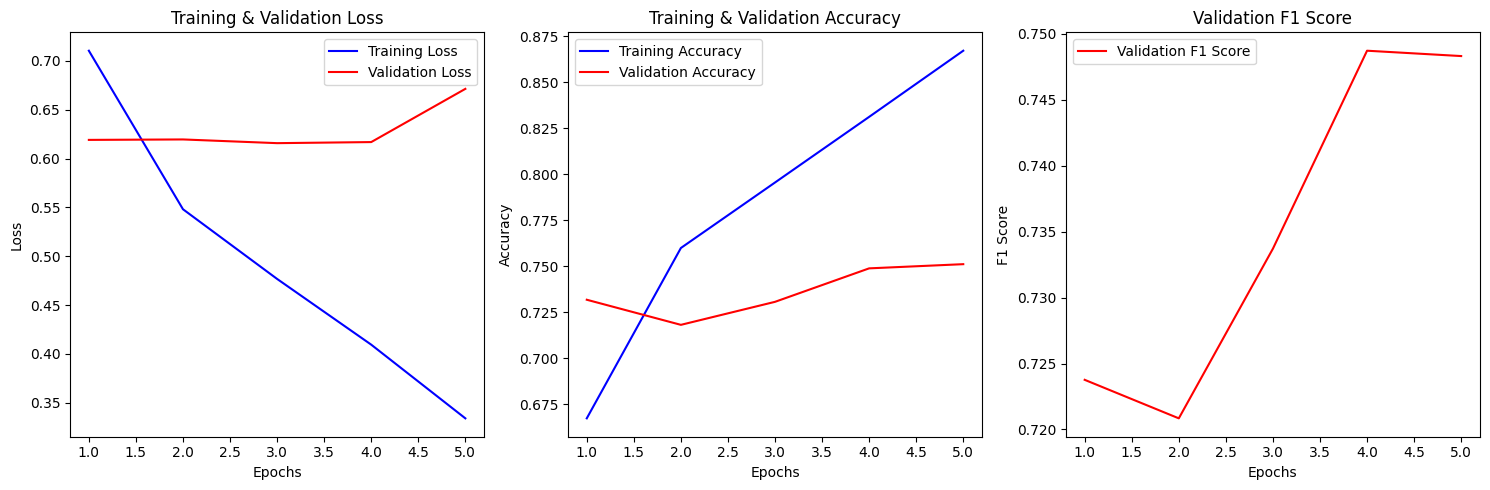

In [27]:
import matplotlib.pyplot as plt

# Your data
epochs_range = list(range(1, len(train_losses) + 1))
training_losses = train_losses
validation_accuracies = val_accuracies
validation_f1_scores = val_f1_scores
validation_losses = val_losses

# Plotting
plt.figure(figsize=(15, 5))

# Plot Training and Validation Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label='Training Loss', color='blue')
plt.plot(epochs_range, val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Plot Training and Validation F1 Score
plt.subplot(1, 3, 3)
plt.plot(epochs_range, val_f1_scores, label='Validation F1 Score', color='red')
# You can also add Training F1 Scores if you've computed them
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()